# NYC-Taxi-FHV-Project


In [1]:
import pandas as pd #DataFrame
import numpy as np #For array
import os #for os commands
from math import sin, cos, sqrt, atan2, radians, log #For calculation
import time           #to get the system time
import datetime       #for datetime operations
import holidays       #For extract date time of holidays
import calendar       #For calendar for datetime operations


pd.set_option('display.max_columns', 500)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="E:/GitHub/NYU-Taxi-project/My First Project-b3735f3b3a9d.json"
#os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="./My Project 14295-223aab171173.json"
from google.cloud import bigquery
client = bigquery.Client()

#For geospatial data
import geopandas as gpd   #For geospatial data
import shapely
import pysal as ps
from fiona.crs import from_epsg
from shapely.geometry import Polygon
import geohash_hilbert as ghh # For geohash code
#import choroplethNYC as cp #For taxi zone map

#For machine learning models
import sklearn
from sklearn.linear_model import LinearRegression, Ridge,BayesianRidge #For lasso and ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

#For visualization purpose
from scipy.misc import imread, imresize, imsave 
from pandas.plotting import scatter_matrix
import scipy         #for other dependancies
import seaborn as sns #for making plots
from scipy.misc import imread, imresize, imsave  
from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_notebook, show
from IPython.display import HTML
from matplotlib.pyplot import *
from matplotlib import cm
from matplotlib import animation
from scipy.misc import imread, imresize, imsave  
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn')

E:\Program Files\Anaconda3\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql
E:\Program Files\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## 1. Data Processing

### 1.1 Query Data from BigQuery

In [11]:
start = time.time()
query = (
"""
SELECT x.travel_time, x.date, x.month, x.day, pickup_hour, pickup_datetime, dropoff_datetime,
    pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude,passenger_count,
    temp,visib,mxpsd,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder
FROM
(
      SELECT *,ROW_NUMBER() OVER(partition by date, pickup_hour) as row_number
      FROM
      (
            SELECT pickup_datetime, dropoff_datetime, pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude,
            EXTRACT (HOUR FROM pickup_datetime) as pickup_hour,
            EXTRACT (DAY FROM pickup_datetime) as day,
            EXTRACT (MONTH FROM pickup_datetime) as month,
            EXTRACT (DATE FROM pickup_datetime) as date,
            TIMESTAMP_DIFF(TIMESTAMP(dropoff_datetime), TIMESTAMP(pickup_datetime), SECOND) as travel_time,
            passenger_count
            FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2016`
            WHERE pickup_latitude IS NOT NULL AND pickup_longitude IS NOT NULL and
                dropoff_longitude IS NOT NULL and dropoff_latitude IS NOT NULL
      ) x
      where x.travel_time >0
) x
JOIN
(
 select cast(mo as int64) as month,cast(da as int64) as day,temp,visib,mxpsd,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder
 from `bigquery-public-data.noaa_gsod.gsod2016` where stn='725053'
) y on x.month = y.month and x.day = y.day
where x.row_number <= 200
"""
)
data = pd.io.gbq.read_gbq(query,dialect='standard')
       
end = time.time()
print("Time taken by above cell is {} mins.".format(round((end-start)/60,2)))

Time taken by above cell is 4.52 mins.


### 1.1.1 Define Trip Distance

In [12]:
# great circle distance
def haversine_(lat1, lng1, lat2, lng2):
    """calculate haversine distance between two co-ordinates"""
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return(h)

# manhattan distance
def manhattan_distance_pd(lat1, lng1, lat2, lng2):
    """calculate manhatten distance between pick_drop"""
    a = haversine_(lat1, lng1, lat1, lng2)
    b = haversine_(lat1, lng1, lat2, lng1)
    return a + b

data['haversine_distance'] = round(haversine_(data.pickup_latitude,data.pickup_longitude,data.dropoff_latitude,data.dropoff_longitude),3)
data['manhattan_distance'] = round(manhattan_distance_pd(data.pickup_latitude,data.pickup_longitude,data.dropoff_latitude,data.dropoff_longitude),3)

### 1.1.2 Define Day of Week

In [13]:
# create weekday
data["weekday"] = data['date'].dt.dayofweek

### 1.2 Remove Outlier

###  1.2.1 Remove Short & Large Distance

#### Some passengers get on taxi then get off immediately, so the time and distance is near zero. Many rows do have zero for pickup or drop off location or almost same location for pick up and drop off.  Therefore, we are only considered the travel time is at least 60 second and no longer than 5 hours. And, we investage on the distance between 0 and 50 miles

In [6]:
data.loc[(data.haversine_distance == 0) & (data.travel_time <= 60), ['travel_time', 'haversine_distance']].head(10)

,travel_time,haversine_distance
106,12,0.0
160,4,0.0
259,4,0.0
370,3,0.0
928,3,0.0
1190,19,0.0
1250,31,0.0
1295,54,0.0
1451,2,0.0
1460,4,0.0


In [21]:
data = data.loc[(data['haversine_distance'] > 0.5) & (data['haversine_distance']<50)]

###  1.2.2 Remove Short & Large Travel Time

#### In NYC

In [25]:
data = data.loc[(data['travel_time'] > 60) & (data['travel_time'] < 20000)]

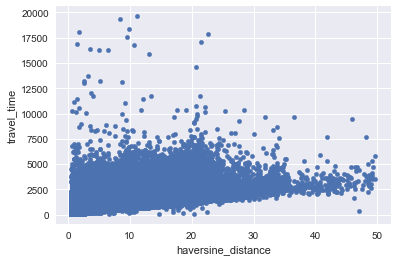

In [26]:
data.plot(x='haversine_distance',y='travel_time',kind='scatter')

### 1.2.3 Clean GPS Coordinates

In [27]:
# clean any pickup not in the NYC
xlim = [-74.03, -73.77]
ylim = [40.63, 40.85]
data = data[(data.pickup_longitude> xlim[0]) & (data.pickup_longitude < xlim[1])]
data = data[(data.dropoff_longitude> xlim[0]) & (data.dropoff_longitude < xlim[1])]
data = data[(data.pickup_latitude> ylim[0]) & (data.pickup_latitude < ylim[1])]
data = data[(data.dropoff_latitude> ylim[0]) & (data.dropoff_latitude < ylim[1])]

### 1.2.4 Remove No Passenger Trip

In [28]:
data = data.loc[data.passenger_count > 0]

### 1.2.5 Clean Weather Data

In [29]:
# refill visib using forward or backward
data['visib'] = data['visib'].replace(999.9, np.nan).fillna(method='ffill')

# refill mxpsd using forward or backward
data['mxpsd'] = data['mxpsd'].replace(999.9, np.nan).fillna(method='ffill')              

# refill wdsp using forward or backward
data['wdsp'] = data['wdsp'].replace(999.9, np.nan).fillna(method='ffill')              

# refill gust as 0
data.loc[(data['gust'] == 999.9), 'gust'] = 0

# refit sndp as 0
data.loc[data['sndp'] == 999.9, 'sndp'] = 0

## 2. Exploratory Data Analysis & Process

### 2.1 Trip Duration vs Hours, Day of Week and Month

#### 2.1.1 Hourly Duration

/Users/franceszhang/anaconda3/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


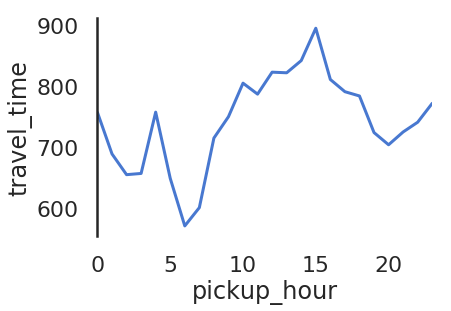

In [12]:
summary_hour_duration = pd.DataFrame(data.groupby('pickup_hour')['travel_time'].median())
summary_hour_duration.reset_index(inplace = True)
summary_hour_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=False)
sns.set_context("poster")
sns.tsplot(data=summary_hour_duration, time="pickup_hour", unit = "unit", value="travel_time")
sns.despine(bottom = True)

#### 2.1.2 Weekly Durations

/Users/franceszhang/anaconda3/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


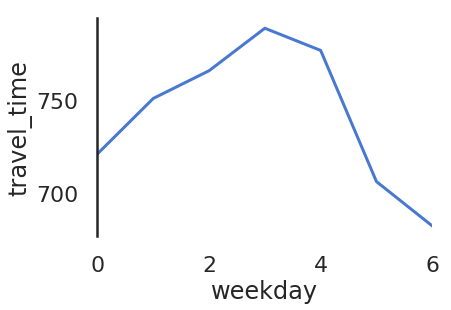

In [13]:
summary_week_duration = pd.DataFrame(data.groupby(['weekday'])['travel_time'].median())
summary_week_duration.reset_index(inplace = True)
summary_week_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=False)
sns.set_context("poster")
sns.tsplot(data=summary_week_duration, time="weekday", unit = "unit", value="travel_time")
sns.despine(bottom = True)

#### 2.1.3 Monthly Duration

/Users/franceszhang/anaconda3/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


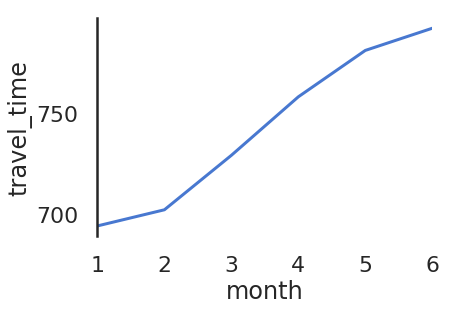

In [14]:
summary_month_duration = pd.DataFrame(data.groupby(['month'])['travel_time'].median())
summary_month_duration.reset_index(inplace = True)
summary_month_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=False)
sns.set_context("poster")
sns.tsplot(data=summary_month_duration, time="month", unit = "unit", value="travel_time")
sns.despine(bottom = True)

#### 2.1.4 Interaction of Hour, Day of Week and Month

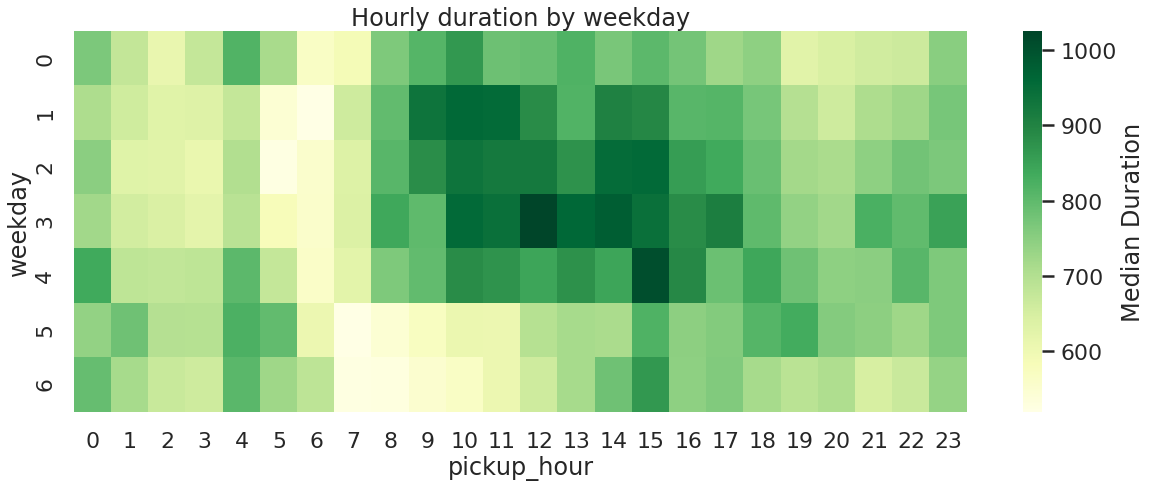

In [15]:
summary_hour_duration = pd.DataFrame(data.groupby(['weekday','pickup_hour'])['travel_time'].median())
summary_hour_duration.reset_index(inplace = True)
summary_hour_duration['unit']=1
heatmap_data1 = summary_hour_duration.pivot(index = 'weekday',columns = 'pickup_hour',values = 'travel_time')
fig,ax=plt.subplots(figsize = (20,7))
plt.title('Hourly duration by weekday')
sns.heatmap(heatmap_data1, cbar_kws={'label': 'Median Duration'}, cmap="YlGn")

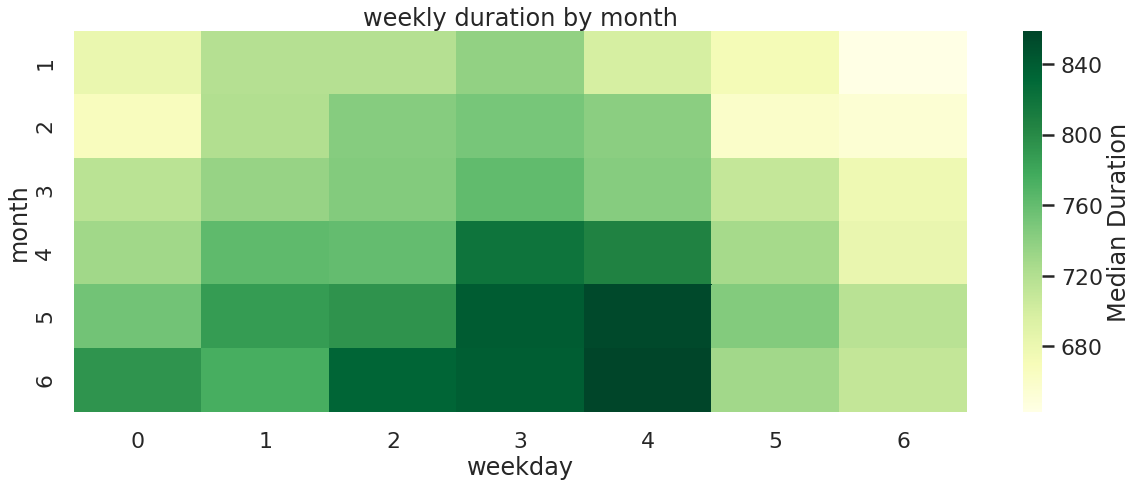

In [16]:
summary_weekday_duration = pd.DataFrame(data.groupby(['weekday','month'])['travel_time'].median())
summary_weekday_duration.reset_index(inplace = True)
summary_weekday_duration['unit']=1
heatmap_data2 = summary_weekday_duration.pivot(index = 'month',columns = 'weekday',values = 'travel_time')
fig,ax=plt.subplots(figsize = (20,7))
plt.title('weekly duration by month')
ax.axis
sns.heatmap(heatmap_data2, cbar_kws={'label': 'Median Duration'}, cmap="YlGn")

### 2.3 Weather Data

#### 2.3.1 Load cleaned weather data

In [30]:
df_weather = pd.read_csv("./Data/tables/weather_2016_cleaned.csv")

#### 2.3.2 Summary of weather data

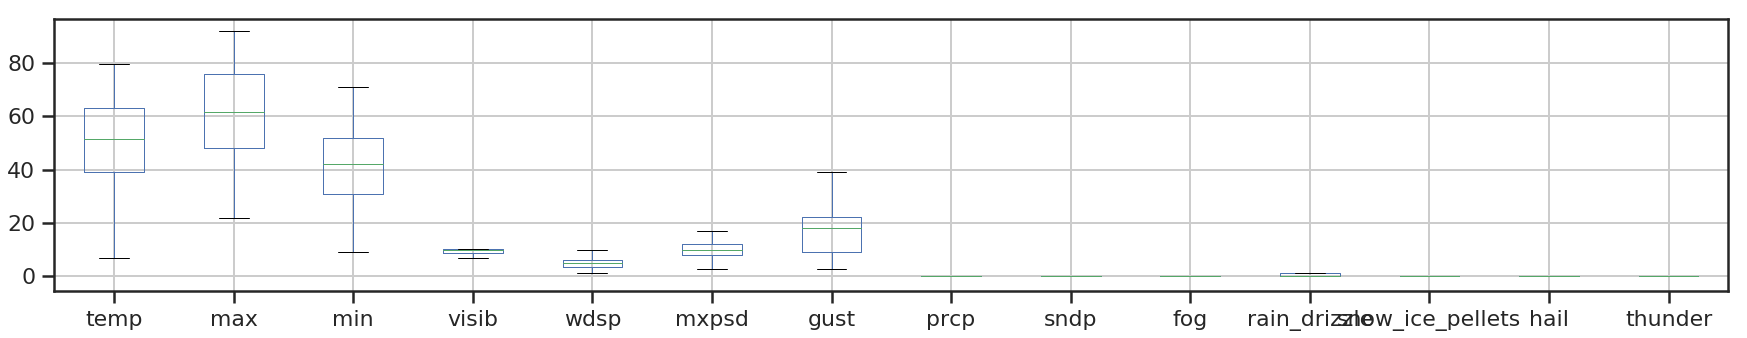

In [19]:
df_weather.boxplot(figsize=(30,5))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000D8D44CB438>,
      dtype=object)

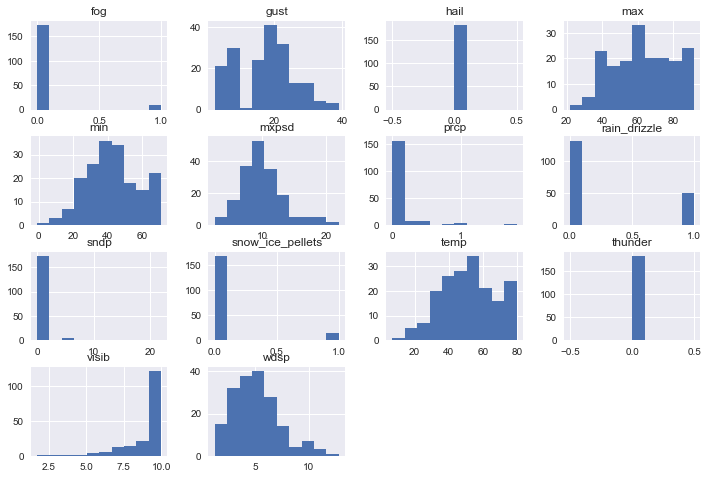

In [33]:
df_weather.hist(figsize=(12,8))

#### 2.3.3 Weather vs Trip Duration

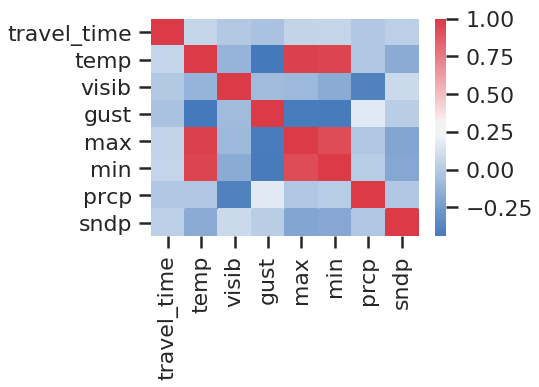

In [21]:
df = data[['date','travel_time', 'temp','visib','mxpsd', 'wdsp', 'gust', 'max', 'min', 'prcp', 'sndp', 
             'fog', 'rain_drizzle', 'snow_ice_pellets', 'hail', 'thunder']]
corr = df.corr()
cmap = sns.diverging_palette(250, 10, sep=20, as_cmap=True)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=cmap)

## 3. Feature Engineer

### 3.1 Transformation of Trip Duration

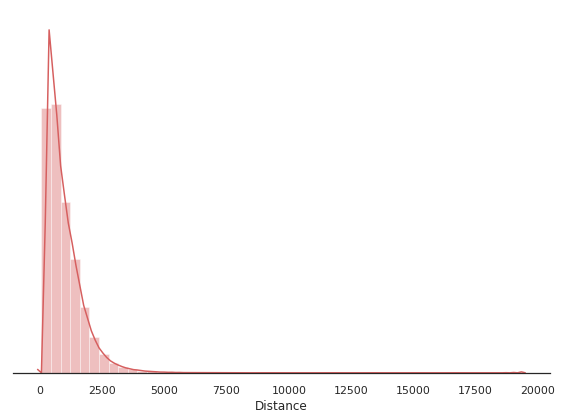

In [22]:
sns.set(style="white", palette="muted", color_codes=True)
ff, axes = plt.subplots(1,1, figsize=(8, 6), sharex=True)
sns.despine(left=True)

sns.distplot(data['travel_time'].values+1, axlabel = 'Distance', label = 'Histogrqm of Distance', bins = 50, color="r")
plt.setp(axes, yticks=[])
plt.tight_layout()

E:\Program Files\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


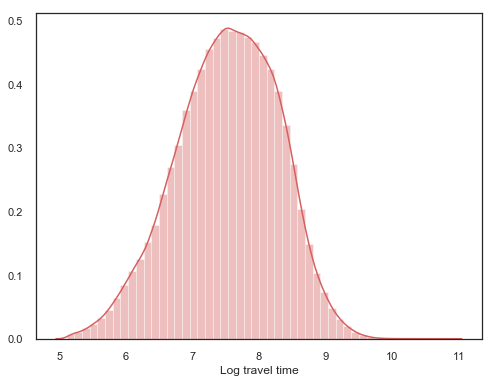

In [34]:
data['log_travel_time'] = np.log(data['travel_time']).values+1

sns.set(style="white", palette="muted", color_codes=True)
ff, axes = plt.subplots(1,1, figsize=(8, 6), sharex=True)
sns.distplot(data['log_travel_time'], axlabel = 'Log travel time', label = 'Histogrqm of Distance', bins = 50, color="r")

### 3.2 Holiday

In [37]:
us_holidays = holidays.UnitedStates()
data['holiday'] = data['date'].apply(lambda x: 1 if x in us_holidays else 0)

,holiday,travel_time
count,798014.000000,798014.000000
mean,0.021769,897.287936
std,0.145929,695.127927
min,0.000000,61.000000
25%,0.000000,406.000000
50%,0.000000,706.000000
75%,0.000000,1200.000000
max,1.000000,19629.000000


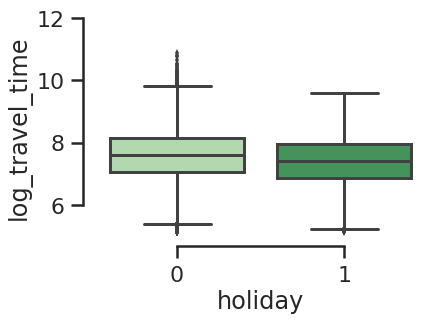

In [25]:
sns.set(style = 'ticks')
sns.set_context("poster")
sns.boxplot(x = "holiday", y = "log_travel_time", data = data, palette = "Greens")
plt.ylim(5,12)
sns.despine(offset = 10, trim = True)

### 3.3 Rush Hour

In [38]:
# create dummy for rush hour
data["rush_hour"] = 0
data.loc[(data["pickup_hour"] >= 8) & (data["pickup_hour"] <= 16),"rush_hour"] = 1

19341


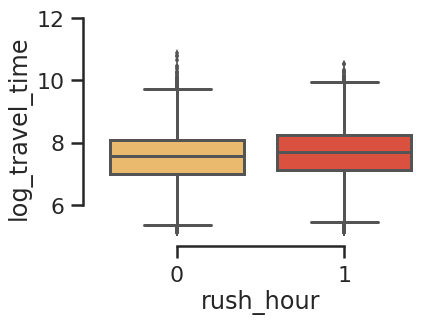

In [27]:
sns.set(style="ticks")
sns.set_context("poster")
sns.boxplot(x="rush_hour", y="log_travel_time", data=data, palette="YlOrRd")
plt.ylim(5, 12)
sns.despine(offset=10, trim=True)
print(data.travel_time.max())

### 3.4 Bearing

In [39]:
def bearing_array(lat1, lng1, lat2, lng2):
    """calculate bearing for each trip"""
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

data['bearing'] = round(bearing_array(data.pickup_latitude,data.pickup_longitude,data.dropoff_latitude,data.dropoff_longitude),3)

### 3.5 Airport Trip

In [40]:
data['airport'] = 0
xlim = [-73.80, -73.77]
ylim = [40.63, 40.66]
data.loc[(data.pickup_longitude> xlim[0]) & (data.pickup_longitude < xlim[1]) &
         (data.pickup_latitude> ylim[0]) & (data.pickup_latitude < ylim[1]), 'airport'] = 1
data.loc[(data.dropoff_longitude> xlim[0]) & (data.dropoff_longitude < xlim[1]) &
         (data.dropoff_latitude> ylim[0]) & (data.dropoff_latitude < ylim[1]), 'airport'] = 1

xlim = [-73.88, -73.85]
ylim = [40.76, 40.78]
data.loc[(data.pickup_longitude> xlim[0]) & (data.pickup_longitude < xlim[1]) &
     (data.pickup_latitude> ylim[0]) & (data.pickup_latitude < ylim[1]), 'airport'] = 1
data.loc[(data.dropoff_longitude> xlim[0]) & (data.dropoff_longitude < xlim[1]) &
     (data.dropoff_latitude> ylim[0]) & (data.dropoff_latitude < ylim[1]), 'airport'] = 1

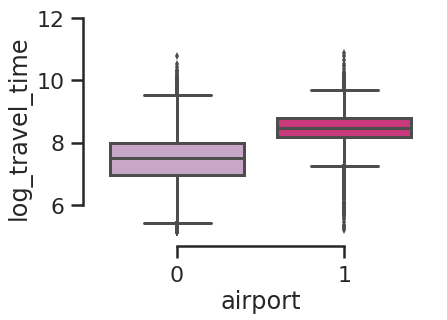

In [30]:
sns.set(style="ticks")
sns.set_context("poster")
sns.boxplot(x="airport", y="log_travel_time", data=data, palette="PuRd")
plt.ylim(5 , 12)
sns.despine(offset=10, trim=True)

### 3.6 Geohash

#### Add geohash to represent location

In [58]:
start = time.time()
pickup = []
dropoff = []
for i in range(len(data)):
    
    dropoff.append(ghh.encode(data.dropoff_longitude.iloc[i], data.dropoff_latitude.iloc[i], precision=5))


data['dropoff_geo'] = dropoff
data["dropoff_geo_recode"] = data["dropoff_geo"].astype('category').cat.codes

end = time.time()
print("Time taken by above cell is {}.".format(round((end-start)/60,2)))

Time taken by above cell is 1.33.


#### Plot geohash map

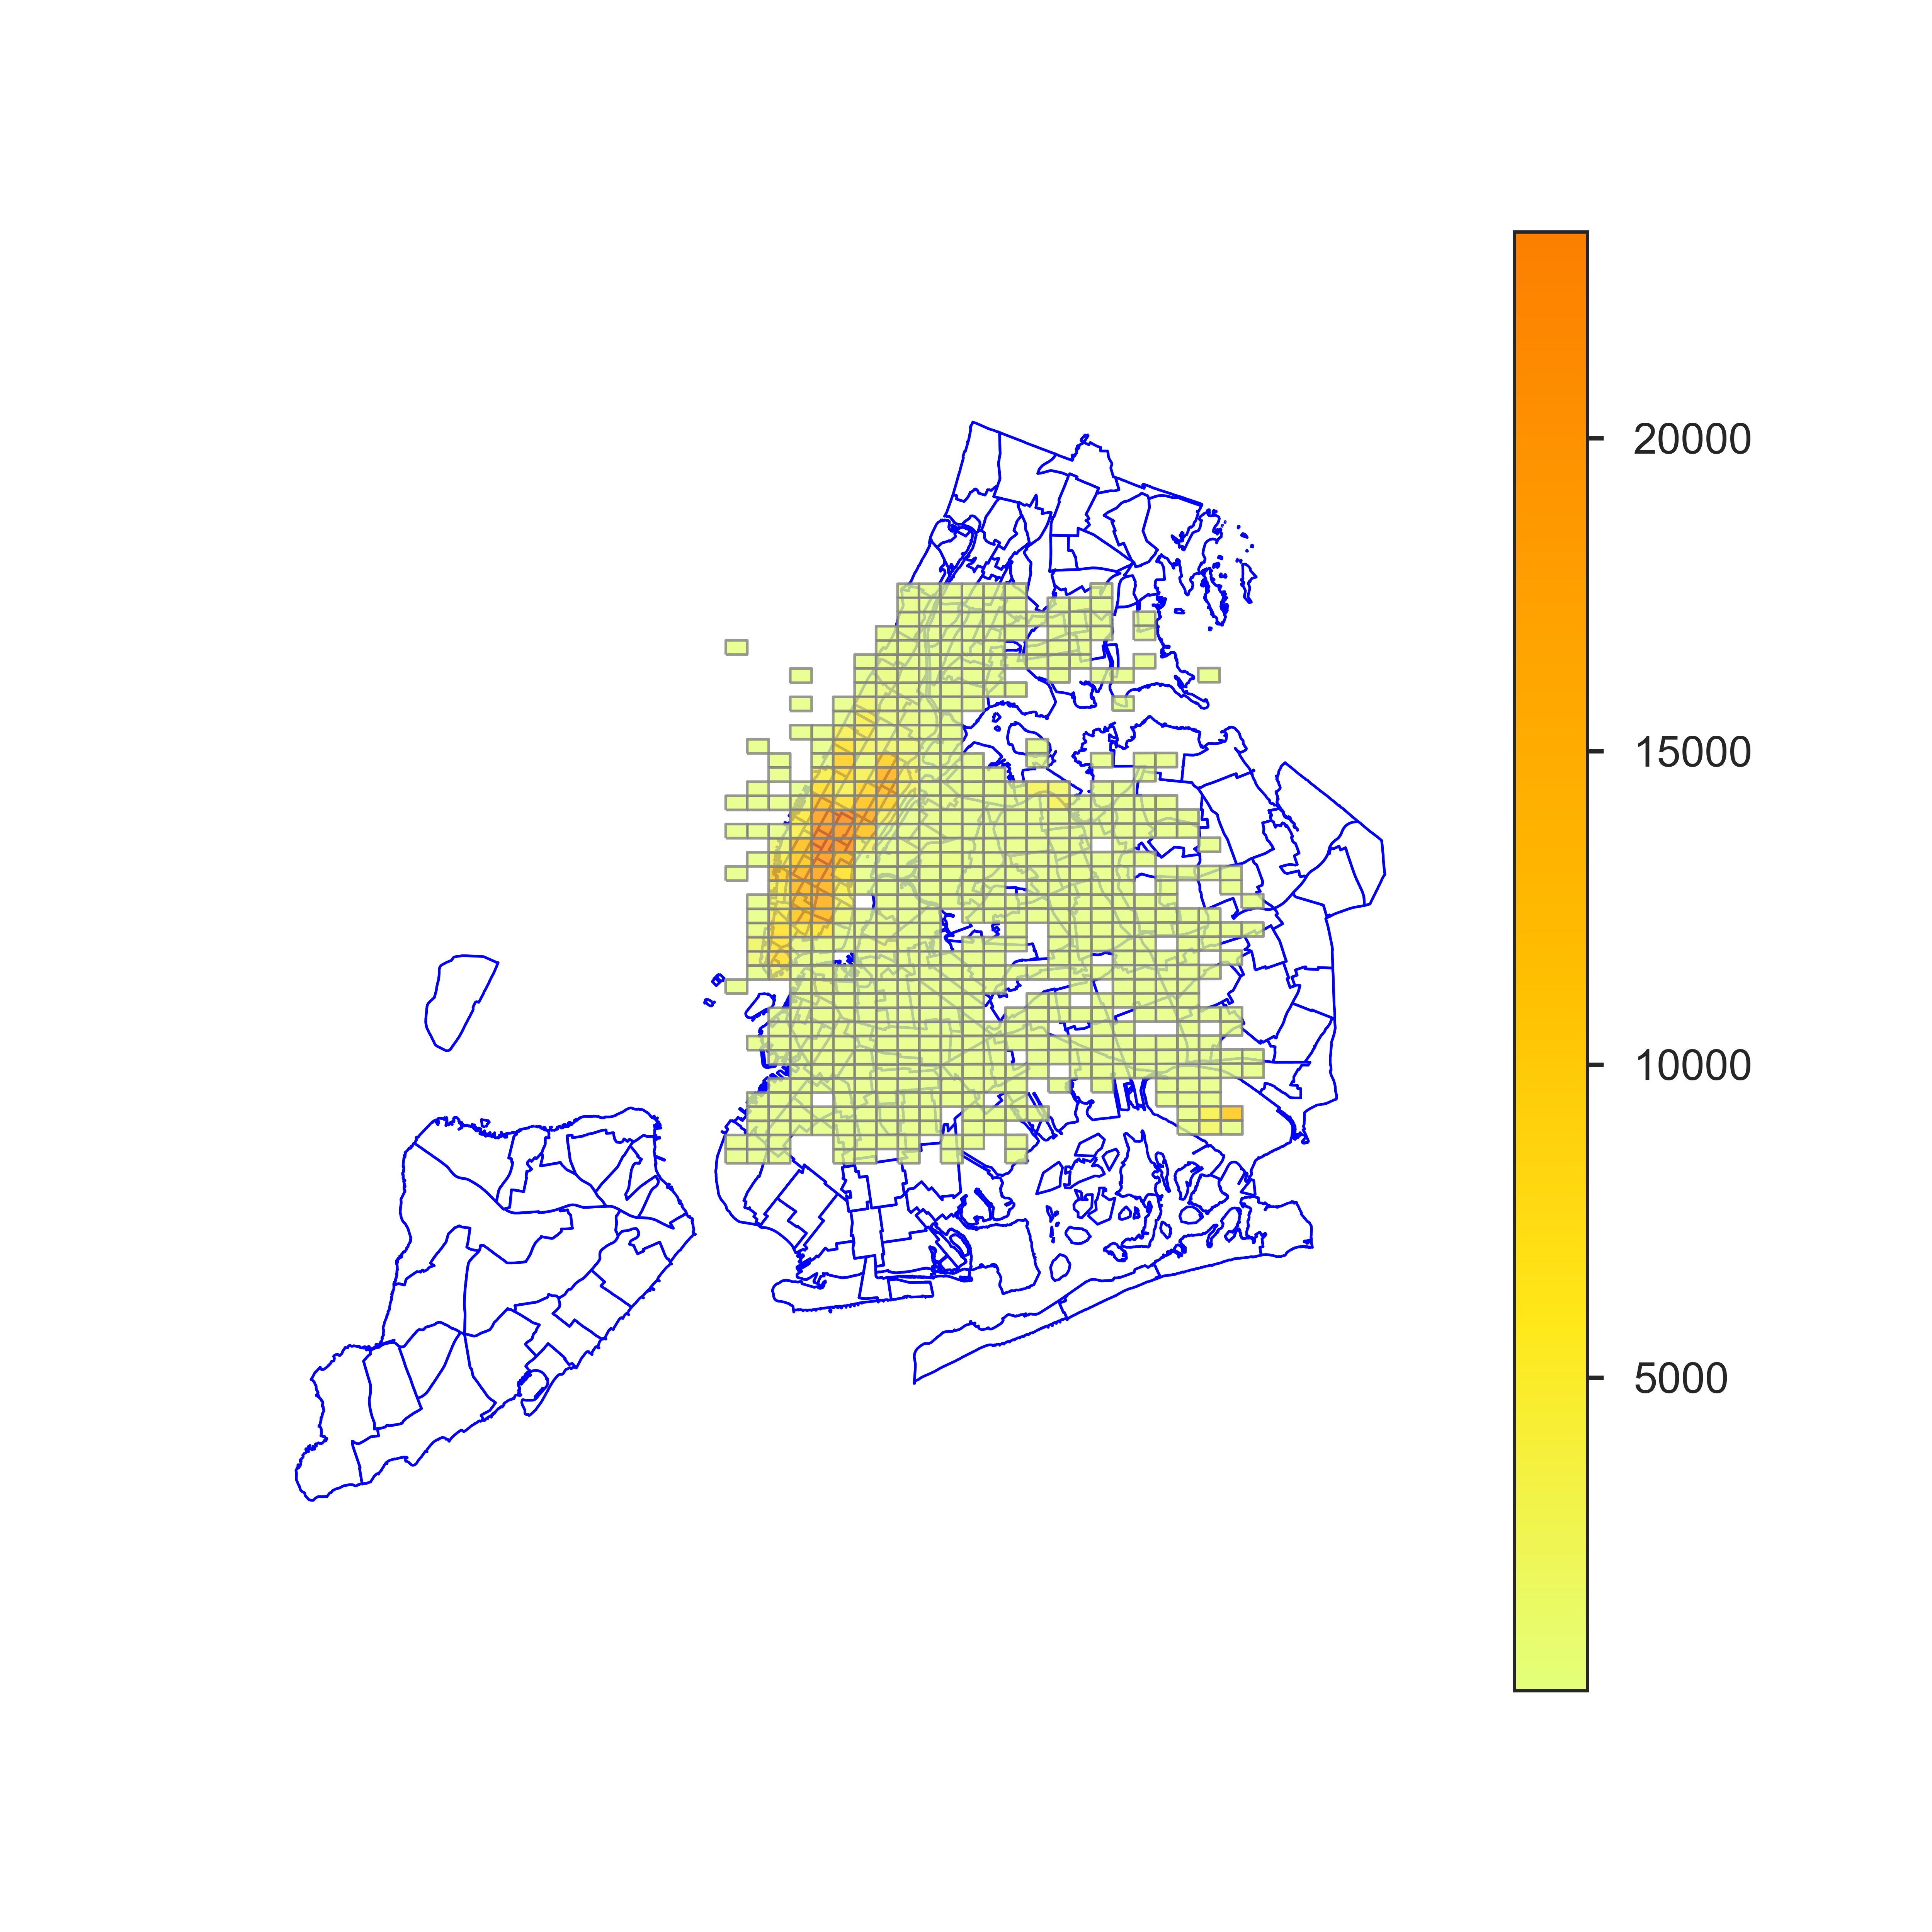

In [33]:
from IPython.display import Image
Image(filename='geohash_pickup.png', width=500, height=300)

## 4. Optimize the memory usage

In [60]:
data = data.drop(['wdsp', 'gust', 'snow_ice_pellets', 'hail', 'thunder','dropoff_geo'], axis = 1)

KeyError: "['wdsp' 'gust' 'snow_ice_pellets' 'hail' 'thunder'] not found in axis"

In [62]:
# Create a function to be calculating memory usage
def get_usage(obj):
    if isinstance(obj, pd.DataFrame):
        usage = obj.memory_usage(deep=True).sum()
    else:
        usage = obj.memory_usage(deep=True)
    return "{:03.2f} MB".format(usage / (1024**2))

# Convert object to int
obj = data.select_dtypes(include = 'object')
#obj = obj.iloc[:,0:7]
obj_f32 = obj.apply(pd.to_numeric, downcast='unsigned')

# Convert int64 to int8
obj = data.select_dtypes(include = 'int64')
obj_int = obj.apply(pd.to_numeric, downcast='unsigned')

# Convert float64 to float32
obj = data.select_dtypes(include = 'float64')
obj_f = obj.apply(pd.to_numeric, downcast='float')

# Calculated the memory we reduced by down grade int and float
print("Original memory usage: ", get_usage(data))
data[obj_f32.columns] = obj_f32
data[obj_int.columns] = obj_int
data[obj_f.columns] = obj_f
print("After converting int and float memory usage: ", get_usage(data))

Original memory usage:  83.72 MB
After converting int and float memory usage:  80.67 MB


In [21]:
data.head()

,travel_time,date,month,day,pickup_hour,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,temp,visib,mxpsd,max,min,prcp,sndp,fog,rain_drizzle,haversine_distance,manhattan_distance,weekday,holiday,rush_hour,bearing,airport,dropoff_geo_recode
0,7.405229,2016-01-24,1,24,14,2016-01-24 14:01:14,2016-01-24 14:11:19,-73.976639,40.782452,-73.987427,40.770359,1,26.700001,7.4,17.1,35.099998,19.9,1.82,5.9,1,0,1.623,2.253,6,0,1,-145.955002,0,454
1,7.949856,2016-01-24,1,24,14,2016-01-24 14:55:50,2016-01-24 15:13:13,-73.986816,40.739422,-73.973244,40.762661,1,26.700001,7.4,17.1,35.099998,19.9,1.82,5.9,1,0,2.826,3.728,6,0,1,23.862000,0,459
2,7.760415,2016-01-24,1,24,14,2016-01-24 14:45:06,2016-01-24 14:59:29,-73.978760,40.745090,-73.986198,40.767422,5,26.700001,7.4,17.1,35.099998,19.9,1.82,5.9,1,0,2.561,3.110,6,0,1,-14.159000,0,455
3,6.966147,2016-01-24,1,24,14,2016-01-24 14:32:17,2016-01-24 14:38:47,-73.969902,40.765556,-73.982101,40.768295,2,26.700001,7.4,17.1,35.099998,19.9,1.82,5.9,1,0,1.072,1.332,6,0,1,-73.484001,0,455
4,7.680855,2016-01-24,1,24,14,2016-01-24 14:51:23,2016-01-24 15:04:40,-73.979858,40.771004,-73.990067,40.749317,5,26.700001,7.4,17.1,35.099998,19.9,1.82,5.9,1,0,2.560,3.271,6,0,1,-160.373001,0,470


## Modeling

In [74]:
selected_features = ['month', 'pickup_hour', 'weekday', 'holiday','rush_hour',
                     'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
                     'temp','visib', 'mxpsd',  'prcp', 'sndp', 'fog', 'passenger_count',
                     'bearing', 'airport','manhattan_distance','haversine_distance', 'dropoff_geo_recode'
                    ]

x = data[selected_features]
y = data['log_travel_time']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

In [75]:
def train_test_model_performance(clf, x_train = x_train, y_train = y_train, x_test = x_test, y_test = y_test):
    
    # Fit a model by providing X and y from training set
    clf.fit(x_train, y_train)
    print(clf)
    # Make prediction on the training data
    y_train_pred = clf.predict(x_train)

    # Make predictions on test data
    y_test_pred = clf.predict(x_test)
    
    # Evaluate
    R2_Train = clf.score(x_train,y_train)
    R2_Test = clf.score(x_test,y_test)
    RMSE_Train = sqrt(mean_squared_error(y_train, y_train_pred))
    RMSE_Test = sqrt(mean_squared_error(y_test, y_test_pred))
#     RMSLE_Train = sqrt(mean_squared_log_error(y_train, y_train_pred))
#     RMSLE_Test = sqrt(mean_squared_log_error(y_test, y_test_pred))
    
    metric_names = ['R2','RMSE']
    metric_values_train = [R2_Train, RMSE_Train]
    metric_values_test = [R2_Test, RMSE_Test]
    all_metrics = pd.DataFrame({'metrics':metric_names,
                                'train':metric_values_train,
                                'test':metric_values_test},columns=['metrics','train','test']).set_index('metrics')
    print(all_metrics)

In [76]:
def cv_model_performance(clf, x_train = x_train, y_train = y_train, x_test = x_test, y_test = y_test):
    
    # Fit a model by providing X and y from training set
    clf.fit(x_train, y_train)
    model = clf.best_estimator_
    print(model)
    
    # Make prediction on the training data
    y_train_pred = model.predict(x_train)

    # Make predictions on test data
    y_test_pred = model.predict(x_test)
    
    # Evaluate
    R2_Train = model.score(x_train,y_train)
    R2_Test = model.score(x_test,y_test)
    RMSE_Train = sqrt(mean_squared_error(y_train, y_train_pred))
    RMSE_Test = sqrt(mean_squared_error(y_test, y_test_pred))
    RMSLE_Train = sqrt(mean_squared_log_error(y_train, y_train_pred))
    RMSLE_Test = sqrt(mean_squared_log_error(y_test, y_test_pred))
    
    metric_names = ['R2','RMSE','RMSLE']
    metric_values_train = [R2_Train, RMSE_Train, RMSLE_Train]
    metric_values_test = [R2_Test, RMSE_Test, RMSLE_Test]
    all_metrics = pd.DataFrame({'metrics':metric_names,
                                'train':metric_values_train,
                                'test':metric_values_test},columns=['metrics','train','test']).set_index('metrics')
    print(all_metrics)

### Random Forest

#### Cross Validation

In [ ]:
start = time.time()

# Choose the type of classifier. /
rf = RandomForestRegressor()

# Choose some parameter combinations to try
param_grid = {'n_estimators': [300,400], 
              'max_features': ['auto'], 
              'max_depth': [40,50], 
              'min_samples_split': [30, 50],
              'n_jobs':[-1]
             }

# read theory
grid_obj = GridSearchCV(rf, param_grid, cv=3, n_jobs = 8, iid=False, verbose=10, scoring='r2')
cv_model_performance(grid_obj)

end = time.time()
print("Time taken by above cell is {}.".format((end-start)/60))

#### Train RF

#### Feature Importance

In [78]:
start = time.time()
# parameters = {'n_estimators': 300,
#              'max_features': 'auto',
#               'max_depth': 50,
#               'min_samples_split': 40,
#               'random_state': 2,
#               'n_jobs': -1,
#               }
# 0.899009  0.839094 25

parameters = {'n_estimators': 300,
             'max_features': 'auto',
              'max_depth': 70,
              'min_samples_split': 150,
              'random_state': 2,
              'n_jobs': -1
              }

rf = RandomForestRegressor(**parameters)
train_test_model_performance(rf)

end = time.time()
print("Time taken by above cell is {}.".format(round(end-start)/60,2))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=150,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=False, random_state=2, verbose=0, warm_start=False)
            train      test
metrics                    
R2       0.852902  0.828674
RMSE     0.293303  0.316114
Time taken by above cell is 17.366666666666667.


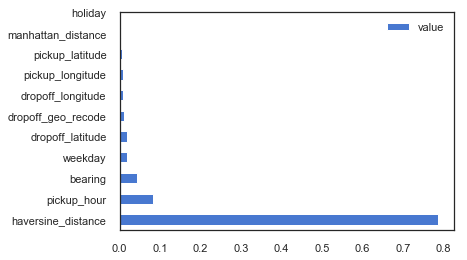

In [69]:
features = pd.DataFrame(list(zip(selected_features, rf.feature_importances_))).sort_values(by=[1], ascending=False)
features.columns = ['feature', 'value']

ax = features.iloc[0:10].plot.barh()
t = np.arange(11)
ax.set_yticks(t)
ax.set_yticklabels(features['feature'])
plt.show()

### Gradient Boosting Trees

#### Cross Validation

In [ ]:
start = time.time()
GBDT = GradientBoostingRegressor()

# Choose some parameter combinations to try
param_grid = {'n_estimators': [250, 300], 
              'max_depth': [10, 11], 
              'learning_rate': [0.2],
              'min_samples_split': [50, 55],
              'subsample':[0.9],
              'random_state': [2]
             }

# read theory
grid_obj = GridSearchCV(GBDT, param_grid, cv=3, n_jobs=8, iid=False, verbose=10, scoring='r2')
cv_model_performance(grid_obj)

end = time.time()
print("Time taken by above cell is {}.".format((end-start)/60))

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed: 301.4min


#### Train GBDT

In [33]:
start = time.time()

#Choose some parameter combinations to try
# parameters = {
#     'n_estimators': 150,
#     'max_depth': 7,
#     'learning_rate': 0.2,
#     'min_samples_split': 30,
#     'max_features': 'auto',
#     'subsample': 0.7,
#     'random_state': 2
# }

#0.797
parameters = {
    'n_estimators': 300,
    'max_depth': 9,
    'learning_rate': 0.2,
    'min_samples_split': 50,
    'subsample': 0.9,
    'random_state': 2
}

GBDT = GradientBoostingRegressor(**parameters)
train_test_model_performance(GBDT)

end = time.time()
print("Time taken by above cell is {}.".format(round((end-start)/60),2))

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.2, loss='ls', max_depth=9, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=50, min_weight_fraction_leaf=0.0,
             n_estimators=300, presort='auto', random_state=2,
             subsample=0.9, verbose=0, warm_start=False)
            train      test
metrics                    
R2       0.895770  0.857926
RMSE     0.244009  0.284756
Time taken by above cell is 80.


#### Feature Improtance

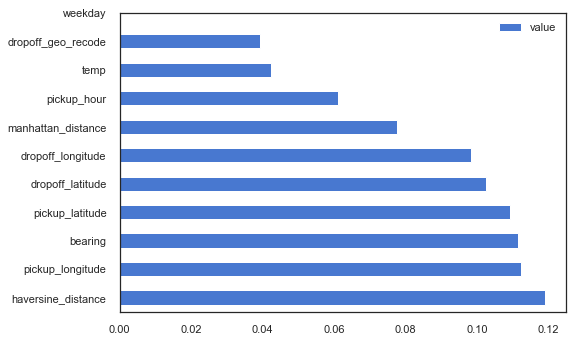

In [34]:
features = pd.DataFrame(list(zip(selected_features, GBDT.feature_importances_))).sort_values(by=[1], ascending=False)
features.columns = ['feature', 'value']
features.head(10)

ax = features.iloc[0:10].plot.barh()
t = np.arange(11)
ax.set_yticks(t)
ax.set_yticklabels(features['feature'])
plt.show()

### Extremely Gradient Boosting (XGB)

#### Spliting Train and Test Data

In [70]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dvalid = xgb.DMatrix(x_test, label=y_test)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

#### Grid Search CV for parameter selection

In [51]:
from sklearn.grid_search import GridSearchCV 

parameters_for_testing = {
   'min_child_weight':[10,15],
   'max_depth':[15,17],
   'alpha':[10,15]
    
}
          
xgb_model = xgb.XGBRegressor(learning_rate =0.1, n_estimators=200, max_depth=12,
    min_child_weight=10, subsample=0.6, colsample_bytree=0.6, nthread= 8, scale_pos_weight=1, seed=27)

gsearch1 = GridSearchCV(estimator = xgb_model, param_grid = parameters_for_testing, cv=3, n_jobs=8,iid=False, verbose=10,scoring='r2')
gsearch1.fit(x_train,y_train)
print (gsearch1.grid_scores_)
print('best params')
print (gsearch1.best_params_)
print('best score')
print (gsearch1.best_score_)

#### Train model 

In [71]:
start = time.time()
xgb_pars = {'min_child_weight': 15, 'eta': 0.1, 'colsample_bytree': 0.7, 
            'max_depth': 15, 'alpha' : 15,
            'subsample': 0.7,'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear','lambda':1}
model = xgb.train(xgb_pars, dtrain, 250, watchlist, early_stopping_rounds=2,
      maximize=False, verbose_eval=1)
print('Modeling RMSE %.5f' % model.best_score)

end = time.time()
print("Time taken by above cell is {}.".format(round((end-start)/60),2))

[0]	train-rmse:6.36269	valid-rmse:6.36817
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 2 rounds.
[1]	train-rmse:5.72929	valid-rmse:5.7345
[2]	train-rmse:5.15952	valid-rmse:5.16449
[3]	train-rmse:4.64703	valid-rmse:4.65181
[4]	train-rmse:4.18621	valid-rmse:4.19075
[5]	train-rmse:3.77168	valid-rmse:3.7761
[6]	train-rmse:3.39899	valid-rmse:3.40324
[7]	train-rmse:3.06389	valid-rmse:3.06797
[8]	train-rmse:2.76282	valid-rmse:2.76678
[9]	train-rmse:2.49215	valid-rmse:2.49595
[10]	train-rmse:2.24974	valid-rmse:2.25348
[11]	train-rmse:2.0314	valid-rmse:2.03505
[12]	train-rmse:1.83543	valid-rmse:1.83897
[13]	train-rmse:1.65978	valid-rmse:1.66325
[14]	train-rmse:1.50235	valid-rmse:1.50574
[15]	train-rmse:1.36125	valid-rmse:1.36463
[16]	train-rmse:1.23531	valid-rmse:1.23862
[17]	train-rmse:1.12298	valid-rmse:1.12631
[18]	train-rmse:1.02263	valid-rmse:1.02595
[19]	train-rmse:0.933298	valid-rmse:0.936637
[20]	tr

[179]	train-rmse:0.275313	valid-rmse:0.28762
[180]	train-rmse:0.275241	valid-rmse:0.28759
[181]	train-rmse:0.275179	valid-rmse:0.287572
[182]	train-rmse:0.275094	valid-rmse:0.287528
[183]	train-rmse:0.274939	valid-rmse:0.287437
[184]	train-rmse:0.274871	valid-rmse:0.287405
[185]	train-rmse:0.274767	valid-rmse:0.287364
[186]	train-rmse:0.274711	valid-rmse:0.287328
[187]	train-rmse:0.274661	valid-rmse:0.287306
[188]	train-rmse:0.27457	valid-rmse:0.287261
[189]	train-rmse:0.274486	valid-rmse:0.28722
[190]	train-rmse:0.274436	valid-rmse:0.287197
[191]	train-rmse:0.27431	valid-rmse:0.287126
[192]	train-rmse:0.274238	valid-rmse:0.287095
[193]	train-rmse:0.274137	valid-rmse:0.287046
[194]	train-rmse:0.27399	valid-rmse:0.286966
[195]	train-rmse:0.273916	valid-rmse:0.286936
[196]	train-rmse:0.273821	valid-rmse:0.286894
[197]	train-rmse:0.273709	valid-rmse:0.286839
[198]	train-rmse:0.27362	valid-rmse:0.286786
[199]	train-rmse:0.273544	valid-rmse:0.286755
[200]	train-rmse:0.273469	valid-rmse:0.28

#### Feature Improtance

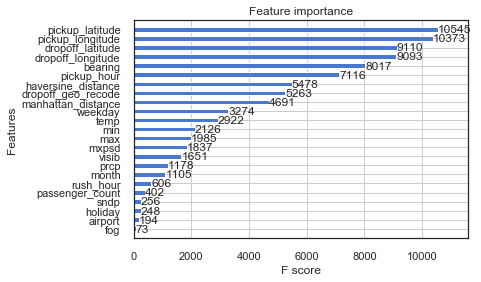

In [72]:
xgb.plot_importance(model, max_num_features=28, height=0.5)

#### Evaluate model performance

In [73]:
# Make prediction on the training data
y_train_pred = model.predict(dtrain)

# Make predictions on test data
y_test_pred = model.predict(dvalid)

# Evaluate
R2_Train = r2_score(y_train_pred, y_train)
R2_Test = r2_score(y_test_pred, y_test)
RMSE_Train = sqrt(mean_squared_error(y_train, y_train_pred))
RMSE_Test = sqrt(mean_squared_error(y_test, y_test_pred))

metric_names = ['R2','RMSE']
metric_values_train = [R2_Train, RMSE_Train]
metric_values_test = [R2_Test, RMSE_Test]
all_metrics = pd.DataFrame({'metrics':metric_names,
                            'train':metric_values_train,
                            'test':metric_values_test},columns=['metrics','train','test']).set_index('metrics')
print(all_metrics)


            train      test
metrics                    
R2       0.854667  0.836563
RMSE     0.269729  0.285038


In [27]:
# Make prediction on the training data
y_train_pred = model.predict(dtrain)

# Make predictions on test data
y_test_pred = model.predict(dvalid)

# Evaluate
R2_Train = r2_score(y_train_pred, y_train)
R2_Test = r2_score(y_test_pred, y_test)
RMSE_Train = sqrt(mean_squared_error(y_train, y_train_pred))
RMSE_Test = sqrt(mean_squared_error(y_test, y_test_pred))

metric_names = ['R2','RMSE']
metric_values_train = [R2_Train, RMSE_Train]
metric_values_test = [R2_Test, RMSE_Test]
all_metrics = pd.DataFrame({'metrics':metric_names,
                            'train':metric_values_train,
                            'test':metric_values_test},columns=['metrics','train','test']).set_index('metrics')
print(all_metrics)

           train      test
metrics                   
R2       0.84290  0.830409
RMSE     0.26525  0.275630


In [29]:
data.shape

(1621627, 29)

## Prediction

In [ ]:
def haversine_(lat1, lng1, lat2, lng2):
    """function to calculate haversine distance between two co-ordinates"""
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = round(2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d)),3)
    return(h)

def manhattan_distance_pd(lat1, lng1, lat2, lng2):
    """function to calculate manhatten distance between pick_drop"""
    a = haversine_(lat1, lng1, lat1, lng2)
    b = haversine_(lat1, lng1, lat2, lng1)
    return a + b

def feature_engineer(data):
    start = time.time()
    
    # create distance_in_km
    data['haversine_distance'] = haversine_(data.pickup_latitude,data.pickup_longitude,data.dropoff_latitude,data.dropoff_longitude)

    # create mahattan dist
    data['manhattan_distance'] = manhattan_distance_pd(data.pickup_latitude,data.pickup_longitude,data.dropoff_latitude,data.dropoff_longitude)

    # create bearing
    data['bearing'] = bearing_array(data.pickup_latitude,data.pickup_longitude,data.dropoff_latitude,data.dropoff_longitude)

    # create weekday
    data["weekday"] = data['pickup_datetime'].dt.dayofweek

    # create holiday
    us_holidays = holidays.UnitedStates()
    data['holiday'] = data['date_of_year'].apply(lambda x: 1 if x in us_holidays else 0)
    
    # K-means clustering
    location = data.loc[:, ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']]
    kmeans = KMeans(n_clusters=50, random_state=123, n_init = 10, n_jobs = 4).fit(location)
    data['cluster'] = kmeans.labels_
  
    # create geo hash (clustering the pickup and dropoff spots)
#     pickup = []
    dropoff = []
    for i in range(len(data)):
        dropoff.append(ghh.encode(data.dropoff_longitude.iloc[i], data.dropoff_latitude.iloc[i], precision=5))

    data['dropoff_geo_recode'] = dropoff
    data["dropoff_geo_recode"] = data["dropoff_geo_recode"].astype('category').cat.codes

    
    end = time.time()
    print("Time taken by above function is {}.".format((end-start)/60))
    
    return(data)

In [ ]:
# Create a function to be calculating memory usage
def get_usage(obj):
    if isinstance(obj, pd.DataFrame):
        usage = obj.memory_usage(deep=True).sum()
    else:
        usage = obj.memory_usage(deep=True)
    return "{:03.2f} MB".format(usage / (1024**2))

def optimizing(data):
    start = time.time()
        
    # Convert object to int
    obj = data.select_dtypes(include = 'object')
    obj_f32 = obj.apply(pd.to_numeric, downcast='unsigned')

    # Convert int64 to int8
    obj = data.select_dtypes(include = 'int64')
    obj_int = obj.apply(pd.to_numeric, downcast='unsigned')

    # Convert float64 to float32
    obj = data.select_dtypes(include = 'float64')
    obj_f = obj.apply(pd.to_numeric, downcast='float')

    # Calculated the memory we reduced by down grade int and float
    print("Original memory usage: ", get_usage(data))
    data[obj_f32.columns] = obj_f32
    data[obj_int.columns] = obj_int
    data[obj_f.columns] = obj_f
    print("After converting int and float memory usage: ", get_usage(data))
    
    end = time.time()
    print("Time taken by above function is {}.".format((end-start)/60))
    
    return(data)

In [ ]:
def pre_processing(data, weather):
    data = data.reset_index()
    weather = weather[['day', 'month', 'prcp', 'sndp', 'fog', 'visib', 'mxpsd', 'wdsp','gust']]
    data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
    data['date_of_year'] = pd.to_datetime(data['pickup_datetime'].dt.date)
    data['month_of_year'] = data['pickup_datetime'].dt.month
    data['pickup_hour'] = data['pickup_datetime'].dt.hour
    data['day_of_year'] = data['pickup_datetime'].dt.day
    data = pd.merge(data, weather, how = 'inner', left_on = ['day_of_year','month_of_year'], right_on = ['day','month'])
    data = data.sort_values(by=['index']).reset_index()
    return(data)

#### Loading Testing Data

In [ ]:
taxi = pd.read_csv("./APM4990_final_test_data_filtered.csv")
weather_2015 = pd.read_csv("./weather_2015_cleaned.csv")

#### Pre-processing

In [ ]:
test = pre_processing(taxi, weather_2015)

#### Feature Engineer

In [ ]:
test = feature_engineer(test)

#### Data Optimiziing

In [ ]:
test = optimizing(test)

In [ ]:
selected_features = ['month_of_year', 'day_of_year', 'pickup_hour', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'cluster',
       'dropoff_latitude', 'passenger_count', 'bearing',  'prcp', 'sndp', 'fog', 'weekday', 'holiday', 'manhattan_distance','haversine_distance','dropoff_geo_recode']

test = test[selected_features]

In [ ]:
y_pred_GBDT = np.exp(GBDT.predict(test))

In [ ]:
result = pd.DataFrame({'predictions':y_pred_GBDT})

In [ ]:
result.to_csv('./result.csv',index = False)